### 1) Understanding Data

* a) Understand Columns
* b) check dtype -> df[col].astype()
* c) Describe Numerical Cols
* d) Describe Categorical Cols

### 2) EXTRACT FEATURES + EDA (uni - bi(heatmap) - multi) -> Insights:
* Uni-variate Analysis
    - Histogram (values)
    - distplot (distrbution)
    - catigorical (pie / count)

* Bi-Variate Analysis
    * Num vs Num
        - Scatter (relationship btn 2 variables)
        - line (trend with time)
    * Num vs Cat (distrbution)
        - box 
        - violin
        - strip
    * Cat vs Cat
        - bar (estimate plot)
        - countplot (count rows)

* Multi-Variate Analysis
    * Pairplot

### 3) Pre-Processing Mind Map:
* a) Detect & Handle Duplicates
* b) train_test_split
* c) Detect & Handle NaNs
* d) Detect & Handle Outliers
* e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])
* f) Imbalanced: X_train_resampled
* g) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled

In [215]:
# Manpulate
import numpy as np
import pandas as pd

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Feature Extraction
import user_agents # get info from user_agent (browser_info)
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo # get location from ip
from geopy.distance import great_circle # distance btn 2 (lat,long)
from geopy.geocoders import Nominatim # geocode("place") / reverse("lat,long")
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # text feature

# Pre-Processing
from sklearn.model_selection import train_test_split # train-test-split
from sklearn.impute import SimpleImputer, KNNImputer # detect & handle NaNs
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, OneHotEncoder # Ordinal Encoding, Nominal Encoding
from category_encoders import BinaryEncoder # Nominal Encoding 
from imblearn.under_sampling import RandomUnderSampler # undersampling
from imblearn.over_sampling import RandomOverSampler, SMOTE # oversampling
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler # Scaling

## Objective

**Goal**: 

Understand the Dataset & cleanup (if required).

Build Regression models to predict the fare price of Uber rides. Also, evaluate the models & compare their respective scores like R², RMSE, etc.

### Dataset Fields

The dataset contains the following fields:

- **key**: A unique identifier for each trip

- **fare_amount**: The cost of each trip in USD

- **pickup_datetime**: Date and time when the meter was engaged

- **passenger_count**: The number of passengers in the vehicle (driver entered value)

- **pickup_longitude**: The longitude where the meter was engaged

- **pickup_latitude**: The latitude where the meter was engaged

- **dropoff_longitude**: The longitude where the meter was disengaged

- **dropoff_latitude**: The latitude where the meter was disengaged


### 1) Understanding Data

* a) Understand Columns
* b) check dtype -> df[col].astype()
* c) Describe Numerical Cols
* d) Describe Categorical Cols

In [216]:
df = pd.read_csv("uber.csv")
df.head()

Unnamed: 0                            key  fare_amount  \
0    24238194    2015-05-07 19:52:06.0000003          7.5   
1    27835199    2009-07-17 20:04:56.0000002          7.7   
2    44984355   2009-08-24 21:45:00.00000061         12.9   
3    25894730    2009-06-26 08:22:21.0000001          5.3   
4    17610152  2014-08-28 17:47:00.000000188         16.0   

           pickup_datetime  pickup_longitude  pickup_latitude  \
0  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         200000 non-null  int64  
 1   key                200000 non-null  object 
 2   fare_amount        200000 non-null  float64
 3   pickup_datetime    200000 non-null  object 
 4   pickup_longitude   200000 non-null  float64
 5   pickup_latitude    200000 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 13.7+ MB


In [218]:
df.describe()

Unnamed: 0    fare_amount  pickup_longitude  pickup_latitude  \
count  2.000000e+05  200000.000000     200000.000000    200000.000000   
mean   2.771250e+07      11.359955        -72.527638        39.935885   
std    1.601382e+07       9.901776         11.437787         7.720539   
min    1.000000e+00     -52.000000      -1340.648410       -74.015515   
25%    1.382535e+07       6.000000        -73.992065        40.734796   
50%    2.774550e+07       8.500000        -73.981823        40.752592   
75%    4.155530e+07      12.500000        -73.967154        40.767158   
max    5.542357e+07     499.000000         57.418457      1644.421482   

       dropoff_longitude  dropoff_latitude  passenger_count  
count      199999.000000     199999.000000    200000.000000  
mean          -72.525292         39.923890         1.684535  
std            13.117408          6.794829         1.385997  
min         -3356.666300       -881.985513         0.000000  
25%           -73.991407         40.733823         1.000000  
50%           -73.980093         40.753042         1.000000  
75%           -73.963658         40.768001         2.000000  
max          1153.572603        872.697628       208.000000

In [219]:
df.columns  

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [220]:
df = df.drop(["Unnamed: 0" , "key"]  , axis=1) 

In [221]:
df.head()

fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5  2015-05-07 19:52:06 UTC        -73.999817        40.738354   
1          7.7  2009-07-17 20:04:56 UTC        -73.994355        40.728225   
2         12.9  2009-08-24 21:45:00 UTC        -74.005043        40.740770   
3          5.3  2009-06-26 08:22:21 UTC        -73.976124        40.790844   
4         16.0  2014-08-28 17:47:00 UTC        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

In [222]:
df.dtypes   

fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

In [223]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['pickup_datetime']

0        2015-05-07 19:52:06+00:00
1        2009-07-17 20:04:56+00:00
2        2009-08-24 21:45:00+00:00
3        2009-06-26 08:22:21+00:00
4        2014-08-28 17:47:00+00:00
                    ...           
199995   2012-10-28 10:49:00+00:00
199996   2014-03-14 01:09:00+00:00
199997   2009-06-29 00:42:00+00:00
199998   2015-05-20 14:56:25+00:00
199999   2010-05-15 04:08:00+00:00
Name: pickup_datetime, Length: 200000, dtype: datetime64[ns, UTC]

In [224]:
df.dtypes

fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dtype: object

In [225]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

### 2) EXTRACT FEATURES + EDA (uni - bi(heatmap) - multi) -> Insights:
* Uni-variate Analysis
    - Histogram (values)
    - distplot (distrbution)
    - catigorical (pie / count)

* Bi-Variate Analysis
    * Num vs Num
        - Scatter (relationship btn 2 variables)
        - line (trend with time)
    * Num vs Cat (distrbution)
        - box 
        - violin
        - strip
    * Cat vs Cat
        - bar (estimate plot)
        - countplot (count rows)

* Multi-Variate Analysis
    * Pairplot

In [226]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.999512         40.723217                1  
1         -73.994710         40.750325                1  
2         -73.962565         40.772647                1  
3         -73.965316         40.803349                3  
4         -73.973082         40.761247                5

### Feature Engineering


In [227]:
df['pickup_year'] = df['pickup_datetime'].dt.year
df['pickup_month'] = df['pickup_datetime'].dt.month
df['pickup_day'] = df['pickup_datetime'].dt.day
df['pickup_hour'] = df['pickup_datetime'].dt.hour # 0-23
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday # 0: Monday, 6: Sunday

In [228]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_year  \
0         -73.999512         40.723217                1         2015   
1         -73.994710         40.750325                1         2009   
2         -73.962565         40.772647                1         2009   
3         -73.965316         40.803349                3         2009   
4         -73.973082         40.761247                5         2014   

   pickup_month  pickup_day  pickup_hour  pickup_weekday  
0             5           7           19               3  
1             7          17           20               4  
2             8          24           21               0  
3             6          26            8               4  
4             8          28           17               3

In [229]:
def season(s):
    if s in [12, 1, 2]:  
        return "winter" 
    elif s in [3, 4, 5]:
        return "spring"
    elif s in [6, 7, 8]:
        return "summer"
    else: 
        return "autumn"
    
# ------------------------------------------  
 
def parts_of_day(d): 
    if d > 5 and d < 12:  # form 6 am to 11 am
        return "morning"
    elif d >= 12 and d < 17: # form 12 pm to 4 pm
        return "afternoon"
    elif d >= 17 and d < 23 : # form 5 pm to 10 pm
        return "evenning"
    else:  
        return "night"  # form 11 pm to 5 am

In [230]:
df['season'] = df['pickup_month'].apply(season)
df['parts_of_day'] = df['pickup_hour'].apply(parts_of_day)

In [231]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_year  \
0         -73.999512         40.723217                1         2015   
1         -73.994710         40.750325                1         2009   
2         -73.962565         40.772647                1         2009   
3         -73.965316         40.803349                3         2009   
4         -73.973082         40.761247                5         2014   

   pickup_month  pickup_day  pickup_hour  pickup_weekday  season parts_of_day  
0             5           7           19               3  spring     evenning  
1             7          17           20               4  summer     evenning  
2             8          24           21               0  summer     evenning  
3             6          26            8               4  summer      morning  
4             8          28           17               3  summer     evenning

In [232]:
df.describe()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
count  200000.000000     200000.000000    200000.000000      199999.000000   
mean       11.359955        -72.527638        39.935885         -72.525292   
std         9.901776         11.437787         7.720539          13.117408   
min       -52.000000      -1340.648410       -74.015515       -3356.666300   
25%         6.000000        -73.992065        40.734796         -73.991407   
50%         8.500000        -73.981823        40.752592         -73.980093   
75%        12.500000        -73.967154        40.767158         -73.963658   
max       499.000000         57.418457      1644.421482        1153.572603   

       dropoff_latitude  passenger_count    pickup_year   pickup_month  \
count     199999.000000    200000.000000  200000.000000  200000.000000   
mean          39.923890         1.684535    2011.742440       6.281795   
std            6.794829         1.385997       1.856397       3.438925   
min         -881.985513         0.000000    2009.000000       1.000000   
25%           40.733823         1.000000    2010.000000       3.000000   
50%           40.753042         1.000000    2012.000000       6.000000   
75%           40.768001         2.000000    2013.000000       9.000000   
max          872.697628       208.000000    2015.000000      12.000000   

          pickup_day    pickup_hour  pickup_weekday  
count  200000.000000  200000.000000   200000.000000  
mean       15.704670      13.491335        3.048425  
std         8.687409       6.515531        1.946946  
min         1.000000       0.000000        0.000000  
25%         8.000000       9.000000        1.000000  
50%        16.000000      14.000000        3.000000  
75%        23.000000      19.000000        5.000000  
max        31.000000      23.000000        6.000000

In [233]:
def filter_coordinates(df):
    df = df[
        (df['pickup_longitude'] >= -180) & (df['pickup_longitude'] <= 180) & (df['dropoff_longitude'] >= -180) & (df['dropoff_longitude'] <= 180)&
        (df['pickup_latitude'] >= -90) & (df['pickup_latitude'] <= 90) & (df['dropoff_latitude'] >= -90) & (df['dropoff_latitude'] <= 90)]
    return df

df = filter_coordinates(df)
df.head()


fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_year  \
0         -73.999512         40.723217                1         2015   
1         -73.994710         40.750325                1         2009   
2         -73.962565         40.772647                1         2009   
3         -73.965316         40.803349                3         2009   
4         -73.973082         40.761247                5         2014   

   pickup_month  pickup_day  pickup_hour  pickup_weekday  season parts_of_day  
0             5           7           19               3  spring     evenning  
1             7          17           20               4  summer     evenning  
2             8          24           21               0  summer     evenning  
3             6          26            8               4  summer      morning  
4             8          28           17               3  summer     evenning

In [234]:
import haversine as hs  # calculate distance between  2 (lat,long)

travel_distance = []
for index, row in df.iterrows():
    pickup = (row['pickup_latitude'], row['pickup_longitude'])
    drop = (row['dropoff_latitude'], row['dropoff_longitude'])
    travel_distance.append(hs.haversine(pickup, drop))

    
    
df['travel_distance'] = travel_distance

In [235]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_year  \
0         -73.999512         40.723217                1         2015   
1         -73.994710         40.750325                1         2009   
2         -73.962565         40.772647                1         2009   
3         -73.965316         40.803349                3         2009   
4         -73.973082         40.761247                5         2014   

   pickup_month  pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
0             5           7           19               3  spring     evenning   
1             7          17           20               4  summer     evenning   
2             8          24           21               0  summer     evenning   
3             6          26            8               4  summer      morning   
4             8          28           17               3  summer     evenning   

   travel_distance  
0         1.683325  
1         2.457593  
2         5.036384  
3         1.661686  
4         4.475456

In [236]:
# # Extract location name features
# geocoder = Nominatim(user_agent="Get city") # lat, lon
# result = geocoder.reverse("40.740770,-74.005043")
# result.raw.get('address').get('state')  

In [237]:
# def get_location_name(lat, lon):
#     try:
#         result = geocoder.reverse(f"{lat},{lon}")
#         return result.raw.get('address').get('state')
#     except:
#         return None

# df['pickup_location'] = df.apply(lambda row: get_location_name(row['pickup_latitude'], row['pickup_longitude']), axis=1)
# df['dropoff_location'] = df.apply(lambda row: get_location_name(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)
# df.head()

In [238]:
df.fare_amount.unique()

array([ 7.5 ,  7.7 , 12.9 , ..., 37.2 , 86.25, 89.1 ])

In [239]:
df.fare_amount.min()

-52.0

In [240]:
df.fare_amount.max()

499.0

In [241]:
df[df['fare_amount'] <= 0].shape

(22, 15)

In [242]:
df.drop( df[df['fare_amount'] <= 0].index , inplace=True) 
df.reset_index(drop=True, inplace=True)

In [243]:
px.histogram(df, x='fare_amount', nbins=100, title='Fare Amount Distribution')

In [244]:
df[df['fare_amount'] > 200].shape

(7, 15)

In [245]:
df.drop( df[df['fare_amount'] > 200].index , inplace=True)
df.reset_index(drop=True, inplace=True)

In [246]:
px.histogram(df, x='fare_amount', nbins=100, title='Fare Amount Distribution')

In [247]:
df.head()

fare_amount           pickup_datetime  pickup_longitude  pickup_latitude  \
0          7.5 2015-05-07 19:52:06+00:00        -73.999817        40.738354   
1          7.7 2009-07-17 20:04:56+00:00        -73.994355        40.728225   
2         12.9 2009-08-24 21:45:00+00:00        -74.005043        40.740770   
3          5.3 2009-06-26 08:22:21+00:00        -73.976124        40.790844   
4         16.0 2014-08-28 17:47:00+00:00        -73.925023        40.744085   

   dropoff_longitude  dropoff_latitude  passenger_count  pickup_year  \
0         -73.999512         40.723217                1         2015   
1         -73.994710         40.750325                1         2009   
2         -73.962565         40.772647                1         2009   
3         -73.965316         40.803349                3         2009   
4         -73.973082         40.761247                5         2014   

   pickup_month  pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
0             5           7           19               3  spring     evenning   
1             7          17           20               4  summer     evenning   
2             8          24           21               0  summer     evenning   
3             6          26            8               4  summer      morning   
4             8          28           17               3  summer     evenning   

   travel_distance  
0         1.683325  
1         2.457593  
2         5.036384  
3         1.661686  
4         4.475456

In [248]:
df.drop(['pickup_datetime'], axis=1, inplace=True)
df.drop_duplicates(inplace=True)

In [249]:
df.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  passenger_count  pickup_year  pickup_month  pickup_day  \
0         40.723217                1         2015             5           7   
1         40.750325                1         2009             7          17   
2         40.772647                1         2009             8          24   
3         40.803349                3         2009             6          26   
4         40.761247                5         2014             8          28   

   pickup_hour  pickup_weekday  season parts_of_day  travel_distance  
0           19               3  spring     evenning         1.683325  
1           20               4  summer     evenning         2.457593  
2           21               0  summer     evenning         5.036384  
3            8               4  summer      morning         1.661686  
4           17               3  summer     evenning         4.475456

In [250]:
df.passenger_count.unique()


array([  1,   3,   5,   2,   4,   6,   0, 208], dtype=int64)

In [251]:
df.passenger_count.value_counts()


passenger_count
1      138397
2       29422
5       14004
3        8877
4        4275
6        4271
0         708
208         1
Name: count, dtype: int64

In [252]:
df[(df['passenger_count'] <= 0) | (df['passenger_count'] > 6)]

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
333            10.1        -74.013900        40.707800         -73.992300   
908            11.7        -73.981000        40.764600         -73.962900   
926             3.3        -73.979978        40.765821         -73.983894   
2000           15.7        -73.975285        40.750138         -73.974729   
3011            6.1        -73.977900        40.789100         -73.983700   
...             ...               ...              ...                ...   
196758          3.3        -74.000760        40.757637         -74.004852   
197064          7.3          0.000000         0.000000           0.000000   
198831          5.7        -73.980300        40.742800         -73.967900   
198861         12.1        -73.996700        40.737200         -74.008500   
198912          3.7        -73.844310        40.721270         -73.842987   

        dropoff_latitude  passenger_count  pickup_year  pickup_month  \
333            40.749300                0         2011             8   
908            40.778400                0         2011             9   
926            40.766873                0         2012             3   
2000           40.783151                0         2012             4   
3011           40.773600                0         2012             1   
...                  ...              ...          ...           ...   
196758         40.751947                0         2011             1   
197064          0.000000                0         2011            12   
198831         40.755600                0         2011             9   
198861         40.704000                0         2011             8   
198912         40.713435                0         2012             4   

        pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
333              5            7               4  summer      morning   
908              6           12               1  autumn    afternoon   
926             26           18               0  spring     evenning   
2000            20           15               4  spring    afternoon   
3011             7           19               5  winter     evenning   
...            ...          ...             ...     ...          ...   
196758          17           15               0  winter    afternoon   
197064          10           15               5  winter    afternoon   
198831          20           19               1  autumn     evenning   
198861          22           21               0  summer     evenning   
198912          13            8               4  spring      morning   

        travel_distance  
333            4.960577  
908            2.162838  
926            0.349924  
2000           3.671182  
3011           1.791373  
...                 ...  
196758         0.720493  
197064         0.000000  
198831         1.765467  
198861         3.823270  
198912         0.878320  

[709 rows x 14 columns]

In [253]:
df.drop(df[(df['passenger_count'] <= 0) | (df['passenger_count'] > 6)].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [254]:
df.head()

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0          7.5        -73.999817        40.738354         -73.999512   
1          7.7        -73.994355        40.728225         -73.994710   
2         12.9        -74.005043        40.740770         -73.962565   
3          5.3        -73.976124        40.790844         -73.965316   
4         16.0        -73.925023        40.744085         -73.973082   

   dropoff_latitude  passenger_count  pickup_year  pickup_month  pickup_day  \
0         40.723217                1         2015             5           7   
1         40.750325                1         2009             7          17   
2         40.772647                1         2009             8          24   
3         40.803349                3         2009             6          26   
4         40.761247                5         2014             8          28   

   pickup_hour  pickup_weekday  season parts_of_day  travel_distance  
0           19               3  spring     evenning         1.683325  
1           20               4  summer     evenning         2.457593  
2           21               0  summer     evenning         5.036384  
3            8               4  summer      morning         1.661686  
4           17               3  summer     evenning         4.475456

In [255]:
df.pickup_year.unique()

array([2015, 2009, 2014, 2011, 2012, 2010, 2013])

In [256]:
df.pickup_day.unique()

array([ 7, 17, 24, 26, 28, 12, 11, 29, 22, 23, 25,  6, 21,  1, 19,  8, 18,
        3,  4, 10,  5, 31, 13,  2, 16, 15,  9, 30, 20, 14, 27])

In [257]:
for col in ['pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday', 'season', 'parts_of_day']:
    print(f"{col}: {df[col].unique()}")
    print(f"{col}: {df[col].nunique()}")
    print({col: df[col].value_counts()})
    print("\n" )
    print("----------------------------------------------------")
    

pickup_year: [2015 2009 2014 2011 2012 2010 2013]
pickup_year: 7
{'pickup_year': pickup_year
2012    32160
2011    31485
2013    31190
2009    30534
2010    30170
2014    29960
2015    13747
Name: count, dtype: int64}


----------------------------------------------------
pickup_month: [ 5  7  8  6  2 10 12  3  4  9 11  1]
pickup_month: 12
{'pickup_month': pickup_month
5     18814
3     18659
4     18493
6     17741
1     17599
2     16620
10    16167
12    15443
11    15271
9     15216
7     15051
8     14172
Name: count, dtype: int64}


----------------------------------------------------
pickup_day: [ 7 17 24 26 28 12 11 29 22 23 25  6 21  1 19  8 18  3  4 10  5 31 13  2
 16 15  9 30 20 14 27]
pickup_day: 31
{'pickup_day': pickup_day
18    6884
17    6853
8     6838
16    6826
14    6804
9     6768
19    6753
12    6749
11    6730
23    6727
20    6710
22    6664
10    6664
13    6646
7     6617
21    6557
6     6545
15    6504
5     6489
24    6454
28    6393
4     6313
26    6257


In [258]:
num_cat = ['pickup_year', 'pickup_month', 'pickup_weekday', 'season', 'parts_of_day']

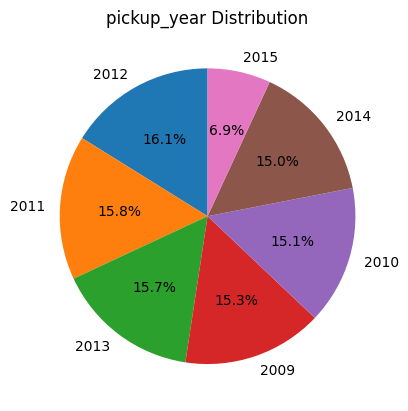

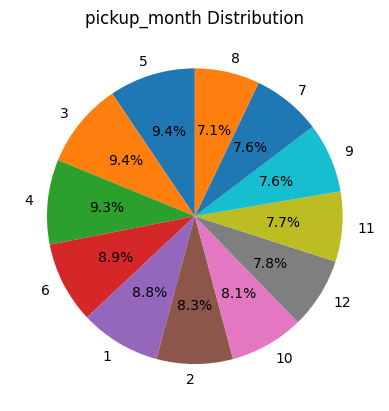

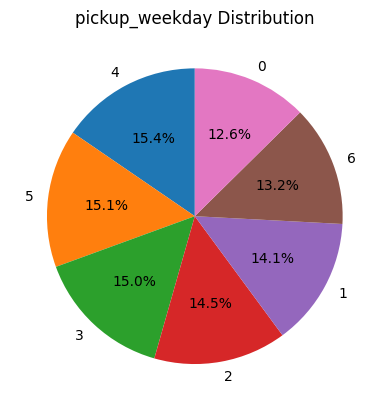

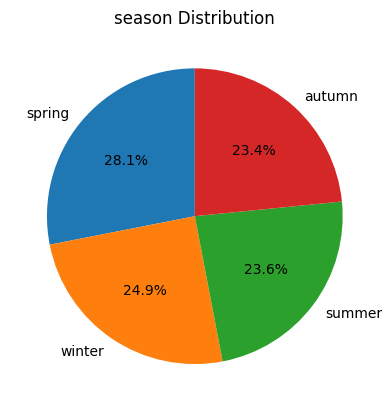

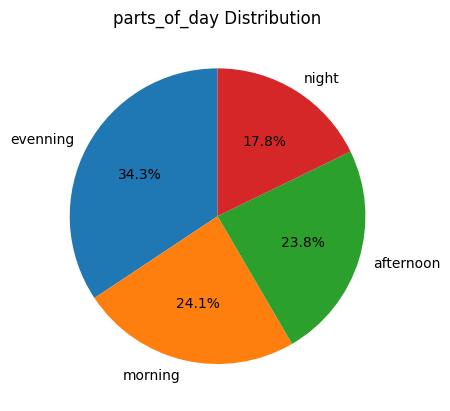

In [259]:
for col in num_cat:
    plt.pie(df[col].value_counts(), labels=df[col].value_counts().index, autopct='%1.1f%%', startangle=90)
    plt.title(f"{col} Distribution")
    plt.show()

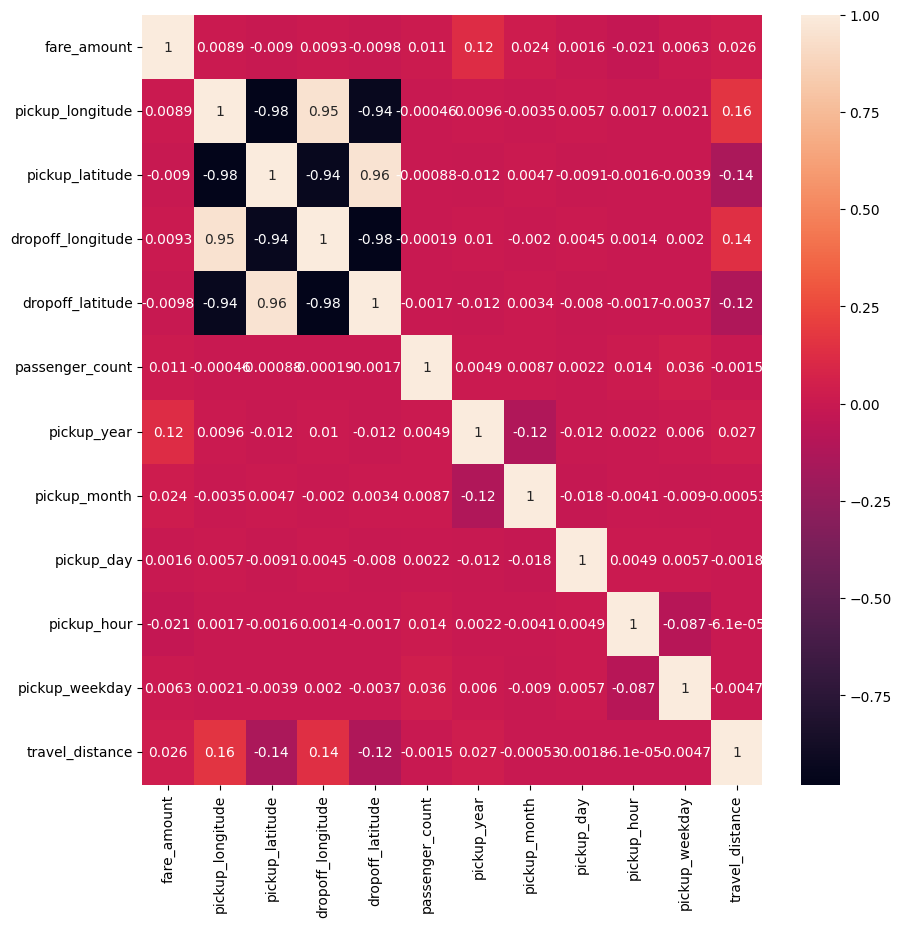

In [260]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True)
plt.show()

<Axes: xlabel='travel_distance', ylabel='fare_amount'>

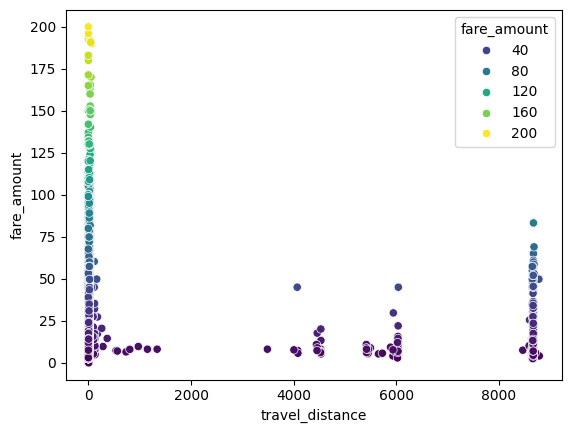

In [261]:
sns.scatterplot(x =df['travel_distance'] , y = df['fare_amount'], hue = df['fare_amount'], palette = 'viridis')

(0.0, 100.0)

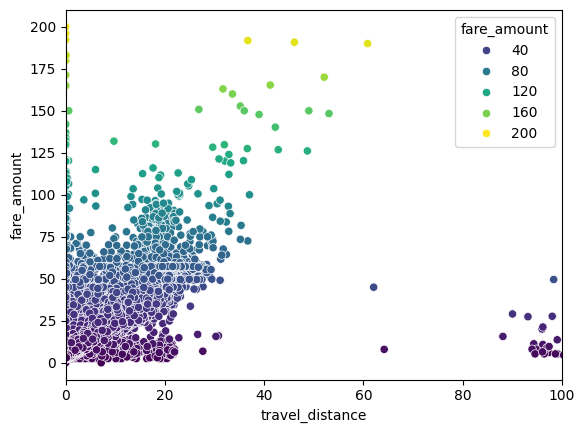

In [262]:
sns.scatterplot(x =df['travel_distance'] , y = df['fare_amount'], hue = df['fare_amount'], palette = 'viridis')
plt.xlim(0, 100)


In [263]:
df[df['travel_distance'] > 60]

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
345            15.5          0.000000         0.000000         -73.979805   
1064           52.0        -73.781095        40.645015           0.000000   
1523            2.5        -74.001849        40.715156           0.000000   
1942            7.0         -0.131667        40.757063         -73.991593   
2163            5.7         -1.216667        40.748597         -74.004822   
...             ...               ...              ...                ...   
197113          7.0        -73.962190        40.759158           0.000000   
197817         23.5        -73.968115        40.801455           0.000000   
197915         20.1         -0.116667        40.729775           0.000000   
198650          7.0        -67.370360        39.999790         -73.971058   
198888          8.1        -74.000143        40.742877          -7.995197   

        dropoff_latitude  passenger_count  pickup_year  pickup_month  \
345            40.786030                1         2015             3   
1064            0.000000                1         2014             2   
1523            0.000000                3         2014             5   
1942           40.749953                1         2013             2   
2163           40.734670                1         2012             7   
...                  ...              ...          ...           ...   
197113          0.000000                1         2014            11   
197817          0.000000                2         2013            10   
197915          0.000000                5         2012             6   
198650         40.753000                1         2013             1   
198888         40.759382                5         2012             6   

        pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
345              5           19               3  spring     evenning   
1064             2           22               6  winter     evenning   
1523            12           12               0  spring    afternoon   
1942            10           16               6  winter    afternoon   
2163            21           12               5  summer    afternoon   
...            ...          ...             ...     ...          ...   
197113          18           22               1  autumn     evenning   
197817          21            1               0  autumn        night   
197915          26           21               1  summer     evenning   
198650          20           17               6  winter     evenning   
198888          22           12               4  summer    afternoon   

        travel_distance  
345         8666.409982  
1064        8647.047542  
1523        8666.784380  
1942        6021.122606  
2163        5941.068008  
...                 ...  
197113      8664.401087  
197817      8665.759137  
197915      4528.965938  
198650       565.235363  
198888      5419.541239  

[476 rows x 14 columns]

In [264]:
df.drop(df[df['travel_distance'] > 60].index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [265]:
df

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               7.5        -73.999817        40.738354         -73.999512   
1               7.7        -73.994355        40.728225         -73.994710   
2              12.9        -74.005043        40.740770         -73.962565   
3               5.3        -73.976124        40.790844         -73.965316   
4              16.0        -73.925023        40.744085         -73.973082   
...             ...               ...              ...                ...   
198765          3.0        -73.987042        40.739367         -73.986525   
198766          7.5        -73.984722        40.736837         -74.006672   
198767         30.9        -73.986017        40.756487         -73.858957   
198768         14.5        -73.997124        40.725452         -73.983215   
198769         14.1        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  pickup_year  pickup_month  \
0              40.723217                1         2015             5   
1              40.750325                1         2009             7   
2              40.772647                1         2009             8   
3              40.803349                3         2009             6   
4              40.761247                5         2014             8   
...                  ...              ...          ...           ...   
198765         40.740297                1         2012            10   
198766         40.739620                1         2014             3   
198767         40.692588                2         2009             6   
198768         40.695415                1         2015             5   
198769         40.768793                1         2010             5   

        pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
0                7           19               3  spring     evenning   
1               17           20               4  summer     evenning   
2               24           21               0  summer     evenning   
3               26            8               4  summer      morning   
4               28           17               3  summer     evenning   
...            ...          ...             ...     ...          ...   
198765          28           10               6  autumn      morning   
198766          14            1               4  spring        night   
198767          29            0               0  summer        night   
198768          20           14               2  spring    afternoon   
198769          15            4               5  spring        night   

        travel_distance  
0              1.683325  
1              2.457593  
2              5.036384  
3              1.661686  
4              4.475456  
...                 ...  
198765         0.112210  
198766         1.875053  
198767        12.850337  
198768         3.539720  
198769         5.417791  

[198770 rows x 14 columns]

In [266]:
cat_cols  = ['passenger_count', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday', 'season', 'parts_of_day']

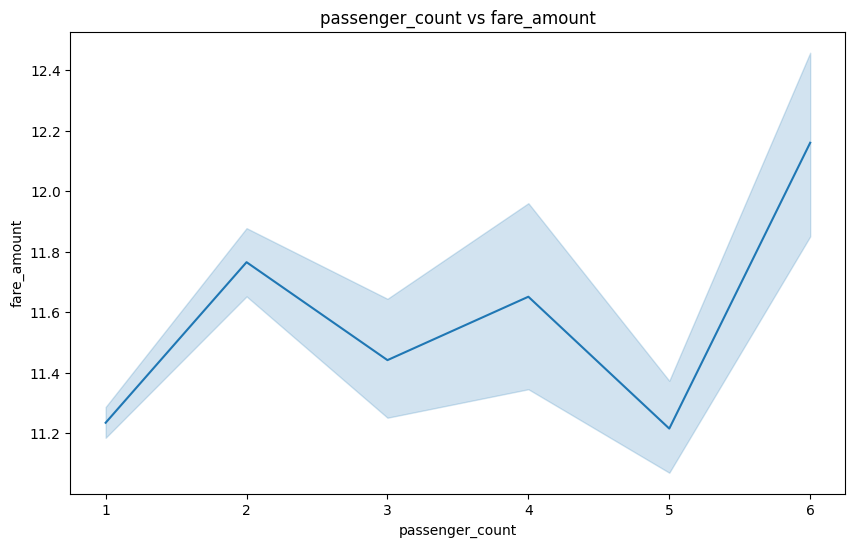

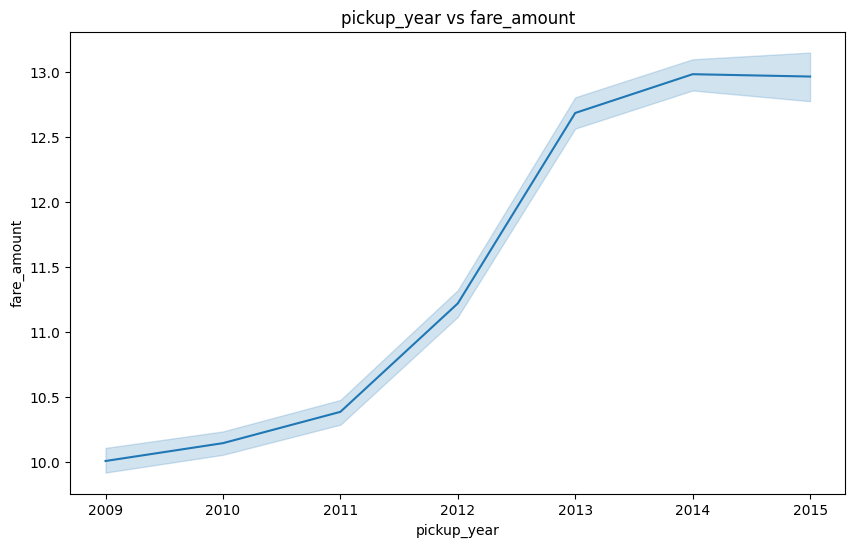

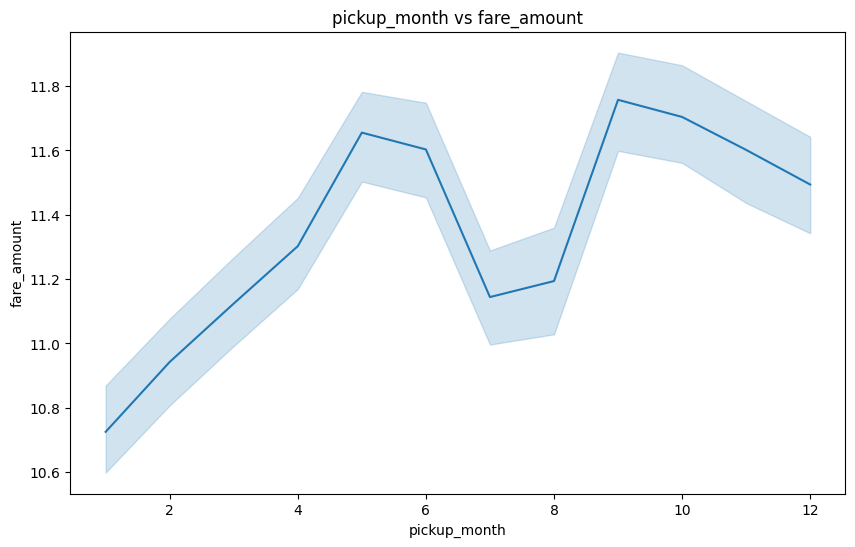

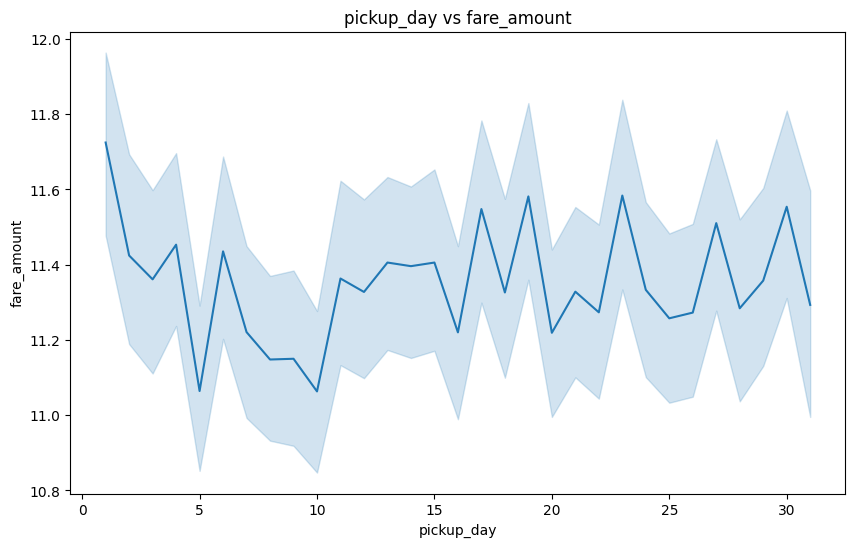

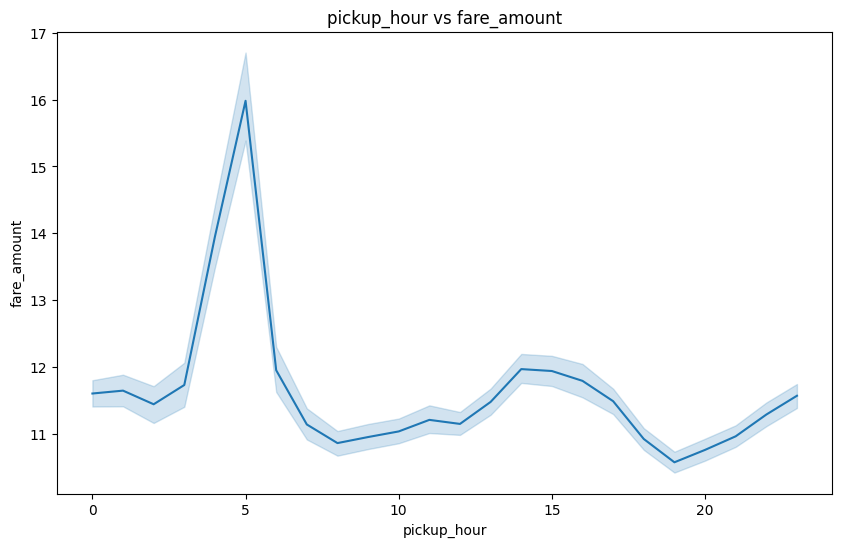

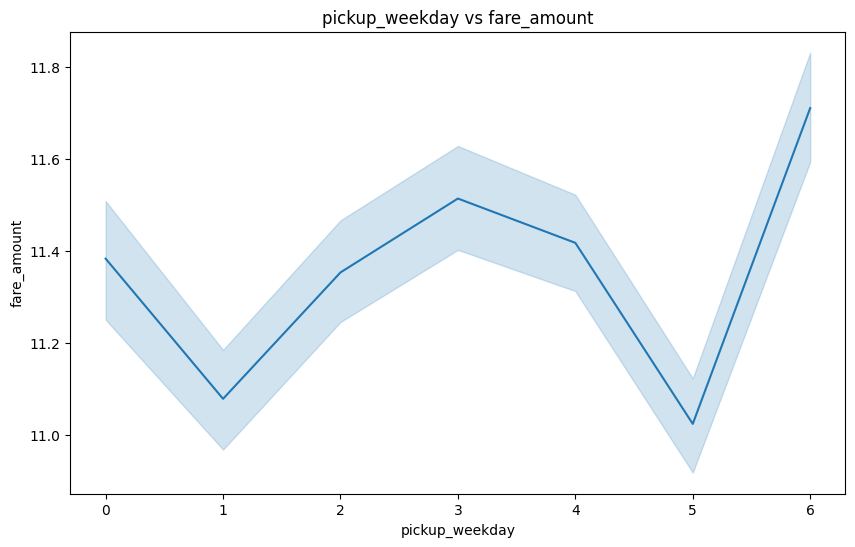

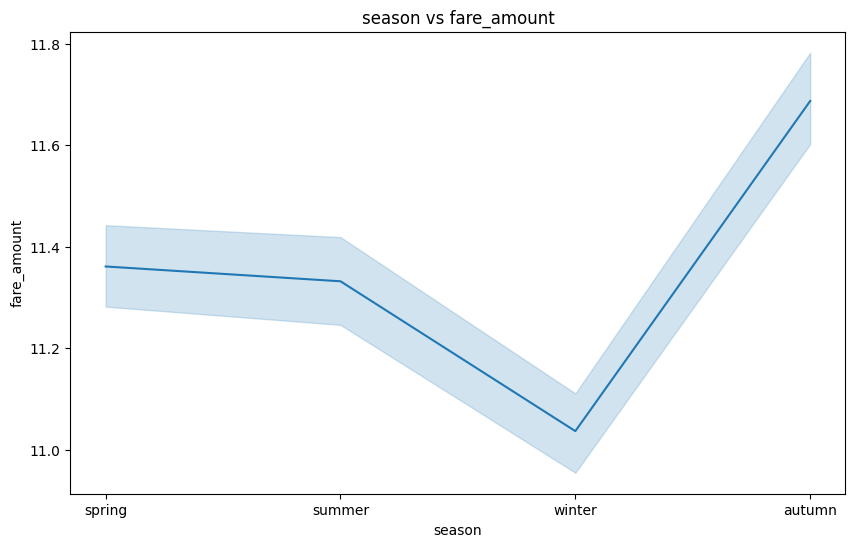

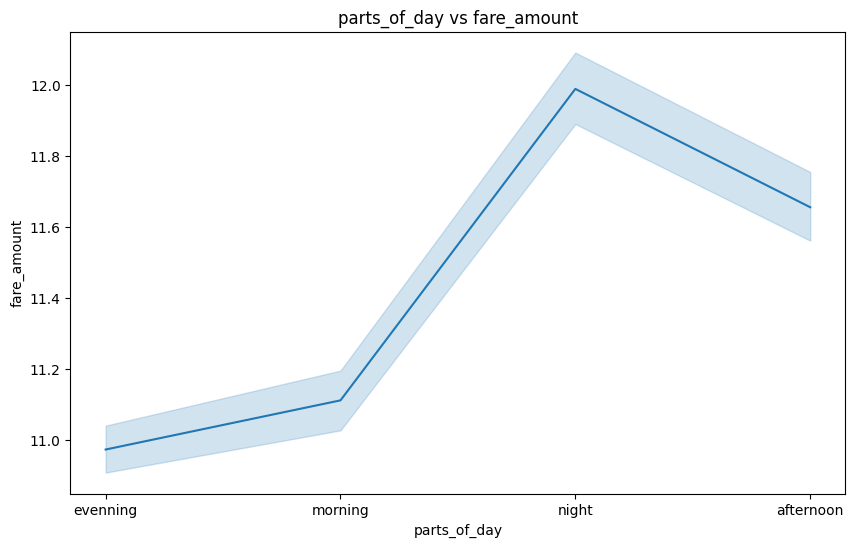

In [267]:
for col in cat_cols:
    plt.figure(figsize=(10, 6))
    sns.lineplot(x=col, y='fare_amount', data=df)
    plt.title(f"{col} vs fare_amount")
    plt.show()

In [268]:
num_cols = ['passenger_count', 'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour', 'pickup_weekday', 'travel_distance']

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\seaborn\axisgrid.py:1513: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-p

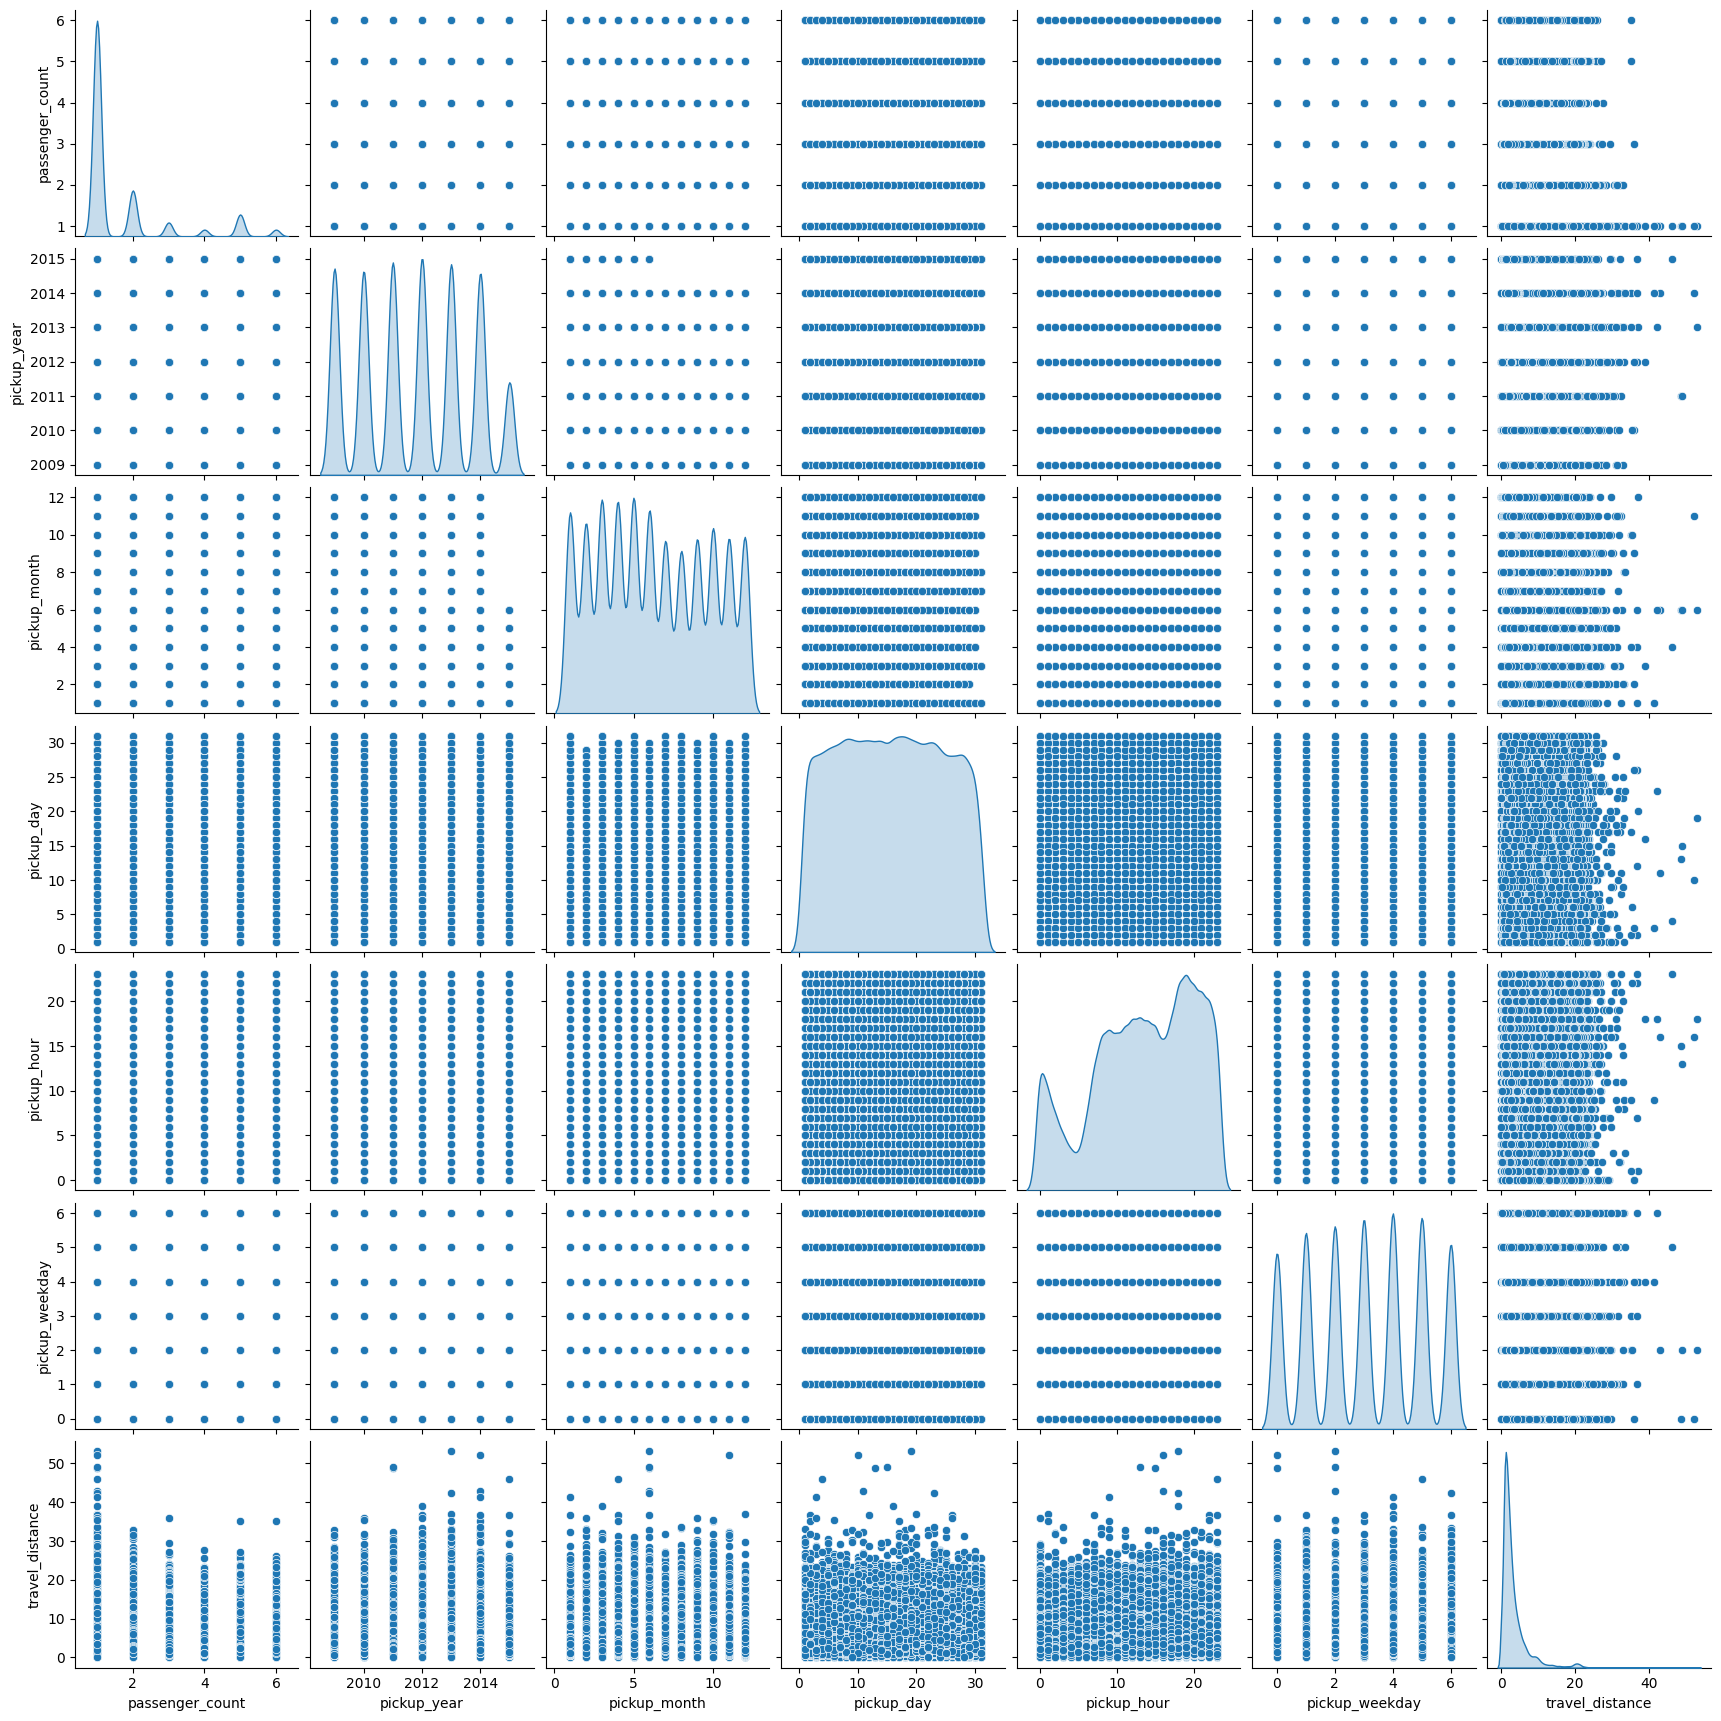

In [269]:
sns.pairplot(df[num_cols], diag_kind='kde', kind='scatter', palette='husl')

In [270]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour',
       'pickup_weekday', 'season', 'parts_of_day', 'travel_distance'],
      dtype='object')

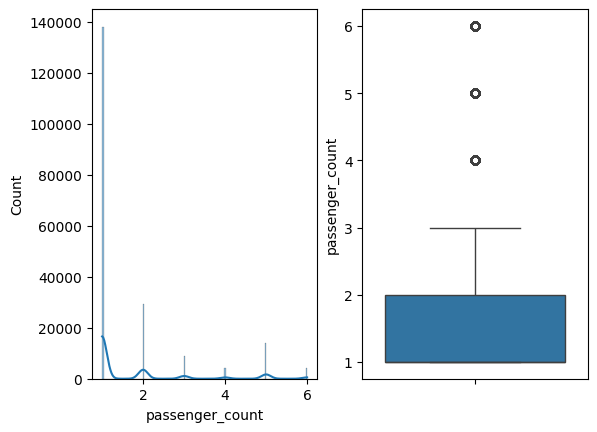

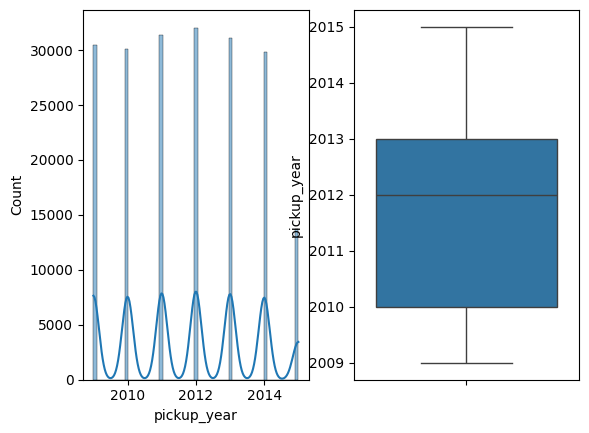

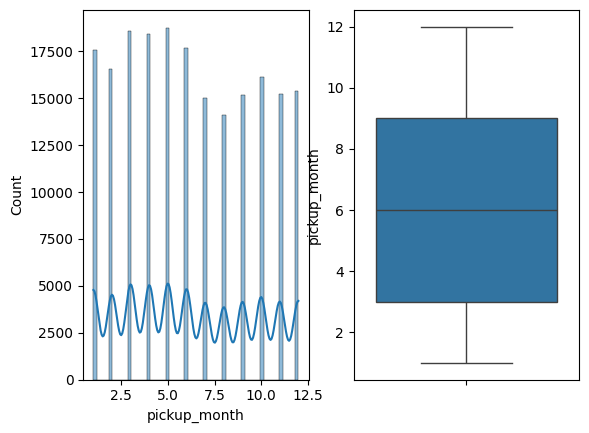

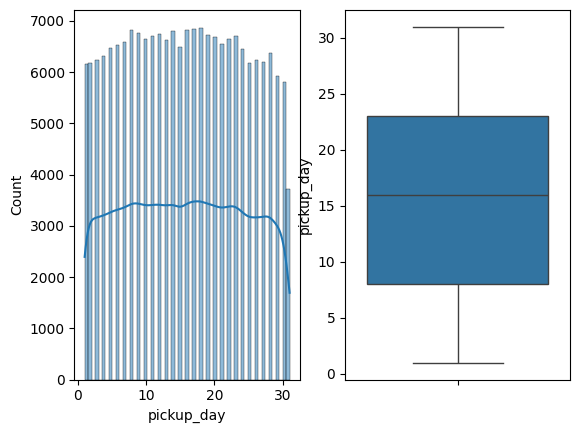

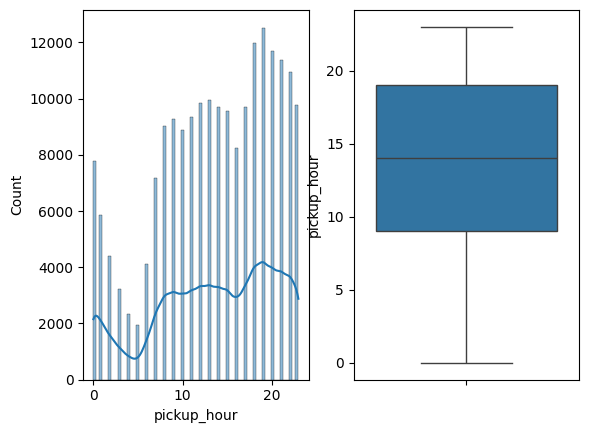

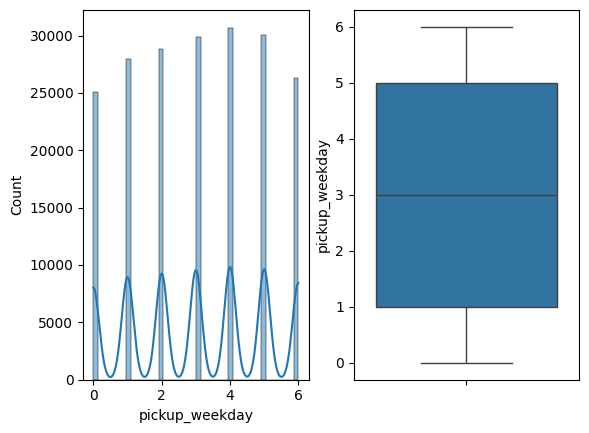

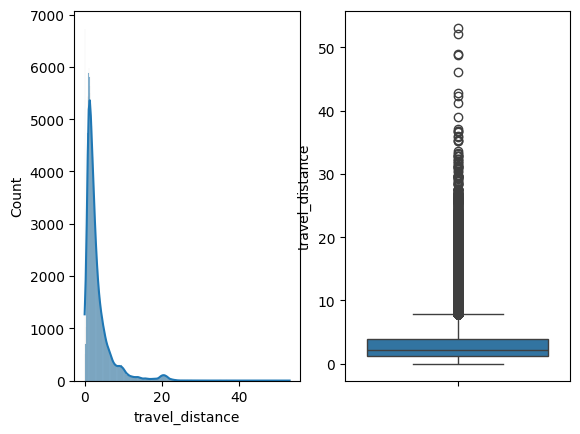

In [271]:
for col in  num_cols :
    fig, axes = plt.subplots(nrows=1, ncols=2)
    sns.histplot(df[col], kde=True, ax=axes[0])
    sns.boxplot(df[col], ax=axes[1])
    plt.show()

In [272]:
df

fare_amount  pickup_longitude  pickup_latitude  dropoff_longitude  \
0               7.5        -73.999817        40.738354         -73.999512   
1               7.7        -73.994355        40.728225         -73.994710   
2              12.9        -74.005043        40.740770         -73.962565   
3               5.3        -73.976124        40.790844         -73.965316   
4              16.0        -73.925023        40.744085         -73.973082   
...             ...               ...              ...                ...   
198765          3.0        -73.987042        40.739367         -73.986525   
198766          7.5        -73.984722        40.736837         -74.006672   
198767         30.9        -73.986017        40.756487         -73.858957   
198768         14.5        -73.997124        40.725452         -73.983215   
198769         14.1        -73.984395        40.720077         -73.985508   

        dropoff_latitude  passenger_count  pickup_year  pickup_month  \
0              40.723217                1         2015             5   
1              40.750325                1         2009             7   
2              40.772647                1         2009             8   
3              40.803349                3         2009             6   
4              40.761247                5         2014             8   
...                  ...              ...          ...           ...   
198765         40.740297                1         2012            10   
198766         40.739620                1         2014             3   
198767         40.692588                2         2009             6   
198768         40.695415                1         2015             5   
198769         40.768793                1         2010             5   

        pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
0                7           19               3  spring     evenning   
1               17           20               4  summer     evenning   
2               24           21               0  summer     evenning   
3               26            8               4  summer      morning   
4               28           17               3  summer     evenning   
...            ...          ...             ...     ...          ...   
198765          28           10               6  autumn      morning   
198766          14            1               4  spring        night   
198767          29            0               0  summer        night   
198768          20           14               2  spring    afternoon   
198769          15            4               5  spring        night   

        travel_distance  
0              1.683325  
1              2.457593  
2              5.036384  
3              1.661686  
4              4.475456  
...                 ...  
198765         0.112210  
198766         1.875053  
198767        12.850337  
198768         3.539720  
198769         5.417791  

[198770 rows x 14 columns]

### 3) Pre-Processing Mind Map:

* a) Detect & Handle Duplicates

* b) train_test_split

* c) Detect & Handle NaNs

* d) Detect & Handle Outliers

* e) Encoding: (Ordinal:[OrdinalEncoder, LabelEncoder] - Nominal: [< 7 uniques(OneHotEncoding), > 7 uniques (BinaryEncoder)])

* f) Imbalanced: X_train_resampled

* g) Scaling: StandardScaler, MinMaxScaler, RobustScaler: X_train_resampled_scaled

### Detect & Handle Duplicates

In [273]:
df.duplicated().sum()   

0

### train_test_split

In [274]:
X = df.drop('fare_amount', axis=1)
y = df['fare_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((159016, 13), (39754, 13), (159016,), (39754,))

### Detect & Handle NaNs

In [275]:
X_train.isna().sum()

pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
pickup_year          0
pickup_month         0
pickup_day           0
pickup_hour          0
pickup_weekday       0
season               0
parts_of_day         0
travel_distance      0
dtype: int64

### Create PipeLine 

In [276]:
from sklearn.base import BaseEstimator, TransformerMixin

class Handle_outliers_lb_ub(BaseEstimator, TransformerMixin):
    
    def fit(self, X):
        self.n_features_in_ = X.shape[1] 
        q1 = np.percentile(X, 25)
        q3 = np.percentile(X, 75)
        iqr = q3 - q1
        ub_train = q3 + 1.5 * iqr
        lb_train = q1 - 1.5 * iqr
        self.ub_train = ub_train
        self.lb_train = lb_train
        return self 

    def transform(self, X):
        assert self.n_features_in_ == X.shape[1]
        X[X > self.ub_train] = self.ub_train
        X[X < self.lb_train] = self.lb_train
        return X
    
h_lb_ub = Handle_outliers_lb_ub()
h_lb_ub

Handle_outliers_lb_ub()

In [277]:
from sklearn.base import BaseEstimator, TransformerMixin
class LogTransfomer(BaseEstimator, TransformerMixin):

    def fit(self, x): 

        self.n_features_in_ = x.shape[1] 
        return self 
    
    def transform(self, x):
        assert self.n_features_in_ == x.shape[1]
        return np.log1p(x)
    
log_transformer = LogTransfomer()
log_transformer

LogTransfomer()

In [278]:
df.columns

Index(['fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_year', 'pickup_month', 'pickup_day', 'pickup_hour',
       'pickup_weekday', 'season', 'parts_of_day', 'travel_distance'],
      dtype='object')

                    outlier             scaling 

travel_distance  :  log_transform 



# make pipeline

# cat1: passenger_count, pickup_year, pickup_month, pickup_weekday, pickup_hour => categorical encoded data
# cat2: pickup_season => OHE, pickup_period => OHE
# num: distance => right-skewed / outliers / 0 -> 53km
# num2: pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude => impute + scaling_robust
# target: fare_amount => right-skewed / outliers

In [279]:
from sklearn.pipeline import Pipeline

pc_py_pm_pw_ph_pipe= Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # passanger_count, pickup_year, pickup_month, pickup_weekday, pickup_hour
])



p_log_p_lat_d_log_d_lat_pipe = Pipeline(steps=[    # pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    ('impute', SimpleImputer(strategy='median')),
    ('scale', RobustScaler())
])



ps_pd_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))  # season ,parts_of_day
])




t_dis_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),    # travel_distance
    ('handle_outliers', LogTransfomer()),
    ('scale', RobustScaler())
])




far_am_pipe = Pipeline(steps=[
    ('handle_outliers', LogTransfomer())  # fare_amount
])



In [280]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(transformers=[
    ("pc_py_pm_pw_ph_pipe", pc_py_pm_pw_ph_pipe, ['passenger_count', 'pickup_year', 'pickup_month', 'pickup_weekday', 'pickup_hour']),
    ("ps_pd_pipe", ps_pd_pipe, ['season' , 'parts_of_day']),
    ("t_dis_pipe", t_dis_pipe, ['travel_distance']),
    ("p_log_p_lat_d_log_d_lat_pipe", p_log_p_lat_d_log_d_lat_pipe, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']),
])

preprocessing

ColumnTransformer(transformers=[('pc_py_pm_pw_ph_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['passenger_count', 'pickup_year',
                                  'pickup_month', 'pickup_weekday',
                                  'pickup_hour']),
                                ('ps_pd_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['seas...
                                ('t_dis_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('handle_outliers',
                                                  LogTransfomer()),
                                                 ('scale', RobustScaler())]),
                                 ['travel_distance']),
                                ('p_log_p_lat_d_log_d_lat_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', RobustScaler())]),
                                 ['pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude'])])

In [281]:
far_am_pipe=  ColumnTransformer(transformers=[
    ("far_am_pipe", far_am_pipe, ['fare_amount']),
])
far_am_pipe

ColumnTransformer(transformers=[('far_am_pipe',
                                 Pipeline(steps=[('handle_outliers',
                                                  LogTransfomer())]),
                                 ['fare_amount'])])

#### 4) Modeling

* 1) Simple Model & Evaluate it's Performance
* 2) Bias vs Variance (Underfitting vs Overfitting)
* 3) GridSearch
* 4) Test Perforamnce & CI
* 5) Save Model

### Simple Model & Evaluate it's Performance

In [282]:
from sklearn.linear_model import LinearRegression

L_R = LinearRegression()
L_R

LinearRegression()

In [283]:
X_train

pickup_longitude  pickup_latitude  dropoff_longitude  \
179447        -73.991782        40.759530         -74.009383   
110802        -73.989849        40.756543         -73.977050   
139008        -73.784190        40.648607         -73.984062   
55336         -74.006119        40.739800         -74.177640   
160017        -73.987863        40.754363         -73.985558   
...                  ...              ...                ...   
119879        -73.928330        40.763523         -73.987212   
103694        -73.975623        40.751691         -74.006742   
131932        -73.993533        40.732949         -73.988239   
146867        -73.973710        40.794720         -73.978890   
121958        -73.991441        40.739759         -74.008947   

        dropoff_latitude  passenger_count  pickup_year  pickup_month  \
179447         40.726025                1         2010             9   
110802         40.757310                1         2010             3   
139008         40.774672                1         2013             6   
55336          40.690386                2         2010             3   
160017         40.727680                1         2011             4   
...                  ...              ...          ...           ...   
119879         40.729313                1         2012             9   
103694         40.713623                2         2012             2   
131932         40.737834                1         2014             6   
146867         40.777181                1         2012             8   
121958         40.731544                1         2009             5   

        pickup_day  pickup_hour  pickup_weekday  season parts_of_day  \
179447           7           15               1  autumn    afternoon   
110802           8            5               0  spring        night   
139008           2           20               6  summer     evenning   
55336           13           18               5  spring     evenning   
160017          27           13               2  spring    afternoon   
...            ...          ...             ...     ...          ...   
119879          27           10               3  autumn      morning   
103694          25           12               5  winter    afternoon   
131932          26           11               3  summer      morning   
146867          22           21               2  summer     evenning   
121958          14           22               3  spring     evenning   

        travel_distance  
179447         4.009838  
110802         1.081412  
139008        21.915760  
55336         15.465082  
160017         2.973367  
...                 ...  
119879         6.251021  
103694         4.979289  
131932         0.702862  
146867         1.998418  
121958         1.734932  

[159016 rows x 13 columns]

In [284]:
X_train_preprocessed = preprocessing.fit_transform(X_train)
X_test_preprocessed = preprocessing.transform(X_test)
X_train_preprocessed

array([[ 1.00000000e+00,  2.01000000e+03,  9.00000000e+00, ...,
         2.12160394e-01, -1.05544071e+00, -7.93286762e-01],
       [ 1.00000000e+00,  2.01000000e+03,  3.00000000e+00, ...,
         1.19652826e-01,  1.10408235e-01,  1.23046732e-01],
       [ 1.00000000e+00,  2.01300000e+03,  6.00000000e+00, ...,
        -3.22313154e+00, -1.42427345e-01,  6.31577406e-01],
       ...,
       [ 1.00000000e+00,  2.01400000e+03,  6.00000000e+00, ...,
        -6.11054763e-01, -2.93039754e-01, -4.47402721e-01],
       [ 1.00000000e+00,  2.01200000e+03,  8.00000000e+00, ...,
         1.30199679e+00,  4.40623329e-02,  7.05065683e-01],
       [ 1.00000000e+00,  2.00900000e+03,  5.00000000e+00, ...,
        -4.00148656e-01, -1.03971962e+00, -6.31635986e-01]])

In [285]:
y_train = far_am_pipe.fit_transform(pd.DataFrame(y_train, columns=['fare_amount']))
y_test = far_am_pipe.transform(pd.DataFrame(y_test, columns=['fare_amount']))

In [286]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

L_R.fit(X_train_preprocessed, y_train) # y_train_loged
y_train_pred = L_R.predict(X_train_preprocessed)

print(f"Train Accuracy: {L_R.score(X_train_preprocessed, y_train)}")
# print(f"Train Loss: {mean_squared_error(y_train, y_train_pred)}")

Train Accuracy: 0.734157710783012


In [287]:
from sklearn.model_selection import cross_val_score, cross_val_predict
valid_accuracies = cross_val_score(L_R, X_train_preprocessed, y_train, scoring='r2', cv=5)
pd.DataFrame(valid_accuracies).describe()

0
count  5.000000
mean   0.734051
std    0.006523
min    0.728163
25%    0.728284
50%    0.731950
75%    0.739652
max    0.742204

#### 2) Bias vs Variance Tradeoff (Underfit vs Overfit)

##### Underfitting Solutions:

* 1) More Complex Model
* 2) Increase Features (Polynomial Features)
* 3) decrease constrains

In [288]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

pc_py_pm_pw_ph_pipe= Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),  # passanger_count, pickup_year, pickup_month, pickup_weekday, pickup_hour
])



p_log_p_lat_d_log_d_lat_pipe = Pipeline(steps=[    # pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude
    ('impute', SimpleImputer(strategy='median')),
    ('scale', RobustScaler())
])



ps_pd_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse_output=False, drop='first'))  # season ,parts_of_day
])




t_dis_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='median')),    # travel_distance
    ('poly', PolynomialFeatures(degree=20, include_bias=False)),
    ('handle_outliers', LogTransfomer()),
    ('scale', RobustScaler())
])




far_am_pipe = Pipeline(steps=[
    ('handle_outliers', LogTransfomer())  # fare_amount
])



In [289]:
poly_preprocessing = ColumnTransformer(transformers=[
    ("pc_py_pm_pw_ph_pipe", pc_py_pm_pw_ph_pipe, ['passenger_count', 'pickup_year', 'pickup_month', 'pickup_weekday', 'pickup_hour']),
    ("ps_pd_pipe", ps_pd_pipe, ['season', 'parts_of_day']),
    ("t_dis_pipe", t_dis_pipe, ['travel_distance']),
    ("p_log_p_lat_d_log_d_lat_pipe", p_log_p_lat_d_log_d_lat_pipe, ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude']),
])

poly_preprocessing

ColumnTransformer(transformers=[('pc_py_pm_pw_ph_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['passenger_count', 'pickup_year',
                                  'pickup_month', 'pickup_weekday',
                                  'pickup_hour']),
                                ('ps_pd_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False))]),
                                 ['seas...
                                                  SimpleImputer(strategy='median')),
                                                 ('poly',
                                                  PolynomialFeatures(degree=20,
                                                                     include_bias=False)),
                                                 ('handle_outliers',
                                                  LogTransfomer()),
                                                 ('scale', RobustScaler())]),
                                 ['travel_distance']),
                                ('p_log_p_lat_d_log_d_lat_pipe',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scale', RobustScaler())]),
                                 ['pickup_longitude', 'pickup_latitude',
                                  'dropoff_longitude', 'dropoff_latitude'])])

In [290]:
far_am_pipe=  ColumnTransformer(transformers=[
    ("far_am_pipe", far_am_pipe, ['fare_amount']),
])
far_am_pipe

ColumnTransformer(transformers=[('far_am_pipe',
                                 Pipeline(steps=[('handle_outliers',
                                                  LogTransfomer())]),
                                 ['fare_amount'])])

In [291]:
poly_lr_model = LinearRegression()

# Ensure the column names in the ColumnTransformer match the dataframe
X_train_preprocessed_poly = poly_preprocessing.fit_transform(X_train)
y_train_transformed = far_am_pipe.fit_transform(pd.DataFrame(y_train, columns=['fare_amount']))

poly_lr_model.fit(X_train_preprocessed_poly, y_train_transformed)
y_train_pred = poly_lr_model.predict(X_train_preprocessed_poly)

print(f"Train Accuracy: {poly_lr_model.score(X_train_preprocessed_poly, y_train_transformed)}")
#print(f"Train Loss: {mean_squared_error(y_true=y_train_transformed, y_pred=y_train_pred)}")


Train Accuracy: 0.758034528439015


In [292]:
lr_model = LinearRegression() 
lr_model.fit(X_train_preprocessed_poly, y_train)

print(f"Train accuracy: {lr_model.score(X_train_preprocessed_poly, y_train)}")
val_acc = cross_val_score(lr_model, X_train_preprocessed_poly, y_train, cv=5, scoring='r2')
pd.DataFrame(val_acc).describe()

Train accuracy: 0.7762461282226465


0
count  5.000000
mean   0.777550
std    0.005198
min    0.772430
25%    0.774747
50%    0.775260
75%    0.779773
max    0.785538

In [293]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV

X_train_preprocessed_poly = poly_preprocessing.fit_transform(X_train)
y_train_preprocessed = far_am_pipe.fit_transform(pd.DataFrame(y_train, columns=['fare_amount']))

lasso_model = Lasso(alpha=0.001, max_iter=2000)
lasso_model.fit(X_train_preprocessed_poly, y_train_preprocessed)

print(f"Train accuracy: {lasso_model.score(X_train_preprocessed_poly, y_train_preprocessed)}")
val_acc = cross_val_score(lasso_model, X_train_preprocessed_poly, y_train_preprocessed, cv=5, scoring='r2')
pd.DataFrame(val_acc).describe()

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.982e+02, tolerance: 3.907e-01



Train accuracy: 0.7505054314478435


c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.431e+02, tolerance: 3.130e-01

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.597e+02, tolerance: 3.124e-01

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.616e+02, tolerance: 3.118e-01

c:\Users\Abdallah\anaconda3\envs\D

0
count  5.000000
mean   0.750429
std    0.005302
min    0.745635
25%    0.745655
50%    0.749223
75%    0.753920
max    0.757711

In [294]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV


elasticnet_model = ElasticNet(alpha=0.05, l1_ratio=0.05 , random_state=42)

X_train_preprocessed_poly = poly_preprocessing.fit_transform(X_train)
y_train_preprocessed = far_am_pipe.fit_transform(pd.DataFrame(y_train, columns=['fare_amount']))

elasticnet_model.fit(X_train_preprocessed_poly, y_train_preprocessed)
y_train_pred = elasticnet_model.predict(X_train_preprocessed_poly)

print(f"Train Accuracy: {elasticnet_model.score(X_train_preprocessed_poly, y_train_preprocessed)}")
val_acc = cross_val_score(elasticnet_model, X_train_preprocessed_poly, y_train_preprocessed, cv=5, scoring='r2')
pd.DataFrame(val_acc).describe()

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.437e+02, tolerance: 3.907e-01



Train Accuracy: 0.7473697990743602


c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.045e+02, tolerance: 3.130e-01

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.914e+02, tolerance: 3.124e-01

c:\Users\Abdallah\anaconda3\envs\DS\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.938e+02, tolerance: 3.118e-01

c:\Users\Abdallah\anaconda3\envs\D

0
count  5.000000
mean   0.747306
std    0.005124
min    0.742551
25%    0.742589
50%    0.746472
75%    0.750672
max    0.754244

In [295]:
from sklearn.linear_model import Lasso, LassoCV, Ridge, RidgeCV, ElasticNet, ElasticNetCV


ridge_lr_model = Ridge(alpha=0.0001, random_state=42 , max_iter=3000)

X_train_preprocessed_poly = poly_preprocessing.fit_transform(X_train)
y_train_preprocessed = far_am_pipe.fit_transform(pd.DataFrame(y_train, columns=['fare_amount']))

ridge_lr_model.fit(X_train_preprocessed_poly, y_train_preprocessed)
y_train_pred = ridge_lr_model.predict(X_train_preprocessed_poly)

print(f"Train Accuracy: {ridge_lr_model.score(X_train_preprocessed_poly, y_train_preprocessed)}")
val_acc = cross_val_score(ridge_lr_model, X_train_preprocessed_poly, y_train_preprocessed, cv=5, scoring='r2')
pd.DataFrame(val_acc).describe()

Train Accuracy: 0.7605350908788777


0
count  5.000000
mean   0.760384
std    0.005043
min    0.755626
25%    0.756045
50%    0.759645
75%    0.762923
max    0.767683

In [296]:
X_test_preprocessed_poly = poly_preprocessing.fit_transform(X_test)
y_test_preprocessed = far_am_pipe.fit_transform(pd.DataFrame(y_test, columns=['fare_amount']))

### Test Perforamnce & CI 

In [297]:
print(f"Train Accuracy: {ridge_lr_model.score(X_train_preprocessed_poly, y_train_preprocessed)}")
print(f"Test Accuracy: {ridge_lr_model.score(X_test_preprocessed_poly, y_test_preprocessed)}")

Train Accuracy: 0.7605350908788777
Test Accuracy: 0.7561126300356908


### Save Model

In [298]:
import joblib

joblib.dump(ridge_lr_model, 'ridge_model.pkl')

['ridge_model.pkl']

In [299]:
best_model = joblib.load('ridge_model.pkl')
